# Learning Curves
Generate learning curves for the default nss and the optimized nss models

In [101]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
#import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from scipy.special import inv_boxcox
from sklearn.model_selection import KFold

# Define functions

In [102]:
def rmse_loss(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [103]:
def custom_learning_curve(model, X, y, y_og, cv, train_sizes):
    """
    Custom implementation of the learning curve with adjusted train sizes based on each fold's available training data.
    """

    # Initialize arrays to store training and testing scores
    train_scores = []
    test_scores = []

    
    # KFold cross-validation
    kf = KFold(n_splits=cv, shuffle=False)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold_idx + 1}/{cv}...")
        print(f"  Test set size: {len(test_idx)}")
        print(f"test indices for this fold: {test_idx}")
        X_train_full, X_test = X[train_idx], X[test_idx]
        y_train_full, y_test = y[train_idx], y[test_idx]
        y_train_full_og, y_test_og = y_og[train_idx], y_og[test_idx]
        
        # Get the size of the current fold's training set
        train_set_size = len(X_train_full)

        # Adjust train_sizes_abs to be based on the current training set size
        train_sizes_abs_fold = [min(int(np.floor(train_set_size * size)) if size <= 1.0 else int(size), train_set_size)
                                for size in train_sizes]

        train_scores_fold = []
        test_scores_fold = []

        # Loop through different training sizes
        for size in train_sizes_abs_fold:
            # Create smaller training set based on current train_size
            X_train = X_train_full[:size]
            y_train = y_train_full[:size]
            y_train_og = y_train_full_og[:size]
            
            # Fit the model on the training set
            model.fit(X_train, y_train)

            # Predict on the training and testing set
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Compute the scores
            train_score = rmse_loss(y_train_og, inv_boxcox(y_train_pred, lambda_boxcox))
            test_score = rmse_loss(y_test_og, inv_boxcox(y_test_pred, lambda_boxcox))

            train_scores_fold.append(train_score)
            test_scores_fold.append(test_score)

        train_scores.append(train_scores_fold)
        test_scores.append(test_scores_fold)

    # Convert results to numpy arrays for easier manipulation later
    train_scores = np.array(train_scores).T  # Shape (n_ticks, cv)
    test_scores = np.array(test_scores).T    # Shape (n_ticks, cv)

    print("\n")
    
    return train_sizes_abs_fold, train_scores, test_scores

In [150]:
def learning_curve_LLOCV(dataframe, num_folds, station_names, model, train_sizes):
    """
    Function that performs leave location out cross validation on water quality time series data.
    The stations are divided into training and testing sets by referring to the unique station_name column.
    """
    
    train_scores = []
    test_scores = []   
    
    kf = KFold(n_splits=num_folds)


    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(station_names)):
        
        print(f"Processing fold {fold_idx + 1}/{num_folds}...")
        print(f"  Test set size: {len(test_idx)}")
        print(f"test indices for this fold: {test_idx}")
        
        station_names_df = pd.DataFrame(station_names, columns=["station_names"])
        train_stations = station_names_df.iloc[train_idx,:]["station_names"].values
        test_stations =  station_names_df.iloc[test_idx,:]["station_names"].values

        train_df = dataframe[dataframe['station_name'].isin(train_stations)]
        test_df = dataframe[dataframe['station_name'].isin(test_stations)]

        
        # Assume the feature columns are all except 'station_name' and 'target_column'

        X_test = test_df.iloc[:,8:]
        y_test = test_df.iloc[:,1]
        y_test_og = test_df.iloc[:,0]
        
        len_train_stations = len(train_stations)
        
        
        train_sizes_abs_fold_stations = [int(np.floor(len_train_stations * size)) if size <= 1.0 else int(size) for size in train_sizes]
        
        train_scores_fold = []
        test_scores_fold = []        
        
        for size in train_sizes_abs_fold_stations:
            
            stations_iter_train = train_stations[:size] 
            train_df_iter = dataframe[dataframe['station_name'].isin(stations_iter_train)]
            
            X_train = train_df_iter.iloc[:,8:]
            y_train = train_df_iter.iloc[:,1]
            y_train_og = train_df_iter.iloc[:,0]
            
            model.fit(X_train, y_train)
        
            # Predict on the training and testing set
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Compute the scores
            train_score = rmse_loss(y_train_og, inv_boxcox(y_train_pred, lambda_boxcox))
            test_score = rmse_loss(y_test_og, inv_boxcox(y_test_pred, lambda_boxcox))

            train_scores_fold.append(train_score)
            test_scores_fold.append(test_score)

        train_scores.append(train_scores_fold)
        test_scores.append(test_scores_fold)

    # Convert results to numpy arrays for easier manipulation later
    train_scores = np.array(train_scores).T  # Shape (n_ticks, cv)
    test_scores = np.array(test_scores).T    # Shape (n_ticks, cv)

    print("\n")
    
    return train_sizes_abs_fold_stations, train_scores, test_scores

# Default MMRS

In [104]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

In [105]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes = {}

# Import monthly data
for i,month in enumerate(months):
    with open(f"final_df_{month}_new", 'rb') as file:
        final_df_month_new = pickle.load(file)
    dataframes[month] = final_df_month_new

In [68]:
# Calculate the learning curve parameters (default NSS)

# Blank dictionaries to save learning curve parameters
train_mean_default_nss = {}
train_std_default_nss = {}
test_mean_default_nss = {}
test_std_default_nss = {}
train_sizes_default_nss = {}
train_scores_default_nss  = {}
test_scores_default_nss = {}



for i, month in enumerate(months):
    print(f'Currently Processing Data for Month: {month}')

    with open(f"X_train_nss_{month}", 'rb') as file:
        X_train_nss = pickle.load(file)
        
    with open(f"y_train_nss_{month}", 'rb') as file:
        y_train_nss = pickle.load(file)
    y_train_nss.reset_index(drop= True, inplace= True)
    
    with open(f"y_train_nss_og_{month}", 'rb') as file:
        y_train_nss_og = pickle.load(file)
    y_train_nss_og.reset_index(drop= True, inplace= True)
    
    learning_curve_model_default_nss = RandomForestRegressor(random_state = 42, n_jobs=32)
    
    train_sizes_default_nss[month], train_scores_default_nss[month], test_scores_default_nss[month] = custom_learning_curve(learning_curve_model_default_nss, X_train_nss, y_train_nss, 
                                                                                                                            y_train_nss_og, 5, np.linspace(0.1, 1.0, 10))
    
    train_mean_default_nss[month] = np.mean(train_scores_default_nss[month], axis=1)
    train_std_default_nss[month] = np.std(train_scores_default_nss[month], axis=1)
    test_mean_default_nss[month] = np.mean(test_scores_default_nss[month], axis=1)
    test_std_default_nss[month] = np.std(test_scores_default_nss[month], axis=1)

Currently Processing Data for Month: jan
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157]
Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202

Processing fold 3/5...
  Test set size: 78
test indices for this fold: [157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234]
Processing fold 4/5...
  Test set size: 78
test indices for this fold: [235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312]
Processing fold 5/5...
  Test set size: 78
test indices for this fold: [313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 

Processing fold 5/5...
  Test set size: 78
test indices for this fold: [313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390]


Currently Processing Data for Month: oct
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 1

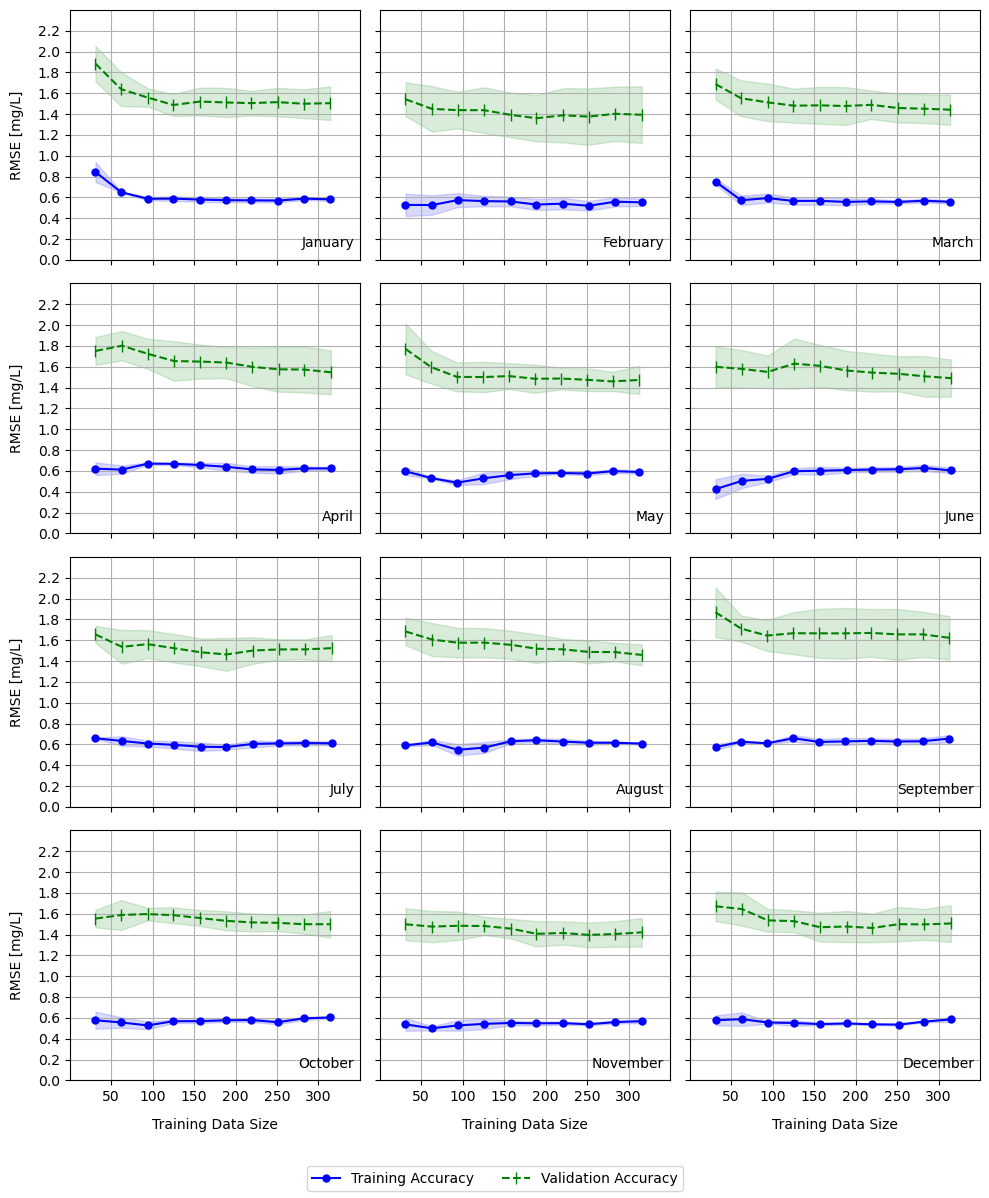

In [126]:
month_long = ['January', 'February', 'March', 'April','May', 'June','July','August','September','October','November','December']

fig = plt.figure(figsize=(10, 12))
# Create a single legend handle list
legend_handles = []
for i, month in enumerate(months):
        
    ax = fig.add_subplot(4, 3, i+1)
    
    line1, = ax.plot(train_sizes_default_nss[month], train_mean_default_nss[month], color='blue', marker='o', markersize=5, label='Training Accuracy')
    ax.fill_between(train_sizes_default_nss[month], train_mean_default_nss[month] + train_std_default_nss[month], train_mean_default_nss[month] - train_std_default_nss[month], alpha=0.15, color='blue')
    line2, = ax.plot(train_sizes_default_nss[month], test_mean_default_nss[month], color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
    ax.fill_between(train_sizes_default_nss[month], test_mean_default_nss[month] + test_std_default_nss[month], test_mean_default_nss[month] - test_std_default_nss[month], alpha=0.15, color='green')
    ax.grid()
    ax.set_xlim(0,350)
    ax.set_xticks(np.arange(50, 301, 50))
    ax.set_ylim(0.2,2.4)
    ax.set_yticks(np.arange(0, 2.3, 0.2))
    #ax.legend(loc='lower right')
    ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
    # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
    if i in range(9,12):
                
        ax.set_xlabel('Training Data Size', labelpad = 10)
        
    # only add y label for the first column of subplot    
    if i in range(0,10,3):        
        ax.set_ylabel('RMSE [mg/L]',labelpad = 10)
        
                
    if i not in range(9,12):
        ax.set_xticklabels([])
    
    
    if i not in range(0,10,3): 
        ax.set_yticklabels([])

    # Collect legend handles from the first plot
    if i == 0:
        legend_handles.extend([line1, line2])


plt.tight_layout(rect=[0, 0.04, 1, 1])

# Create a single legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=2)
plt.savefig('learning_curves_default_nss_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)
plt.show()

## Optimized MMRS

In [83]:
opt_nss_best_params = {}

for i,month in enumerate(months):
    with open(f"study_opt_nss_bc_best_params_{month}", 'rb') as file:
        opt_nss_best_params_month = pickle.load(file)
    opt_nss_best_params[month] = opt_nss_best_params_month

In [84]:
# calculate learning curve parameters (OPT NSS)

train_mean_opt_nss = {}
train_std_opt_nss = {}
test_mean_opt_nss = {}
test_std_opt_nss = {}
train_sizes_opt_nss = {}
train_scores_opt_nss  = {}
test_scores_opt_nss = {}

for i, month in enumerate(months):
    print(f'Currently Processing Data for Month: {month}')
    
    with open(f"X_train_nss_{month}", 'rb') as file:
        X_train_nss = pickle.load(file)
        
    with open(f"y_train_nss_{month}", 'rb') as file:
        y_train_nss = pickle.load(file)
    y_train_nss.reset_index(drop= True, inplace= True)
    
    with open(f"y_train_nss_og_{month}", 'rb') as file:
        y_train_nss_og = pickle.load(file)
    y_train_nss_og.reset_index(drop= True, inplace= True)   
        
    best_n_estimators_opt_merged = opt_nss_best_params[month]['n_estimators']
    best_max_depth_opt_merged = opt_nss_best_params[month]['max_depth']
    best_min_samples_split_opt_merged = opt_nss_best_params[month]['min_samples_split']
    best_min_samples_leaf_opt_merged = opt_nss_best_params[month]['min_samples_leaf']
    
    
    learning_curve_model_opt_nss = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged, max_depth = best_max_depth_opt_merged , 
                                              min_samples_split= best_min_samples_split_opt_merged, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged, random_state=42, n_jobs=32)
    
    train_sizes_opt_nss[month], train_scores_opt_nss[month], test_scores_opt_nss[month] = custom_learning_curve(learning_curve_model_opt_nss, X_train_nss, y_train_nss, 
                                                                                                                            y_train_nss_og, 5, np.linspace(0.1, 1.0, 10))
    train_mean_opt_nss[month] = np.mean(train_scores_opt_nss[month], axis=1)
    train_std_opt_nss[month] = np.std(train_scores_opt_nss[month], axis=1)
    test_mean_opt_nss[month] = np.mean(test_scores_opt_nss[month], axis=1)
    test_std_opt_nss[month] = np.std(test_scores_opt_nss[month], axis=1)

Currently Processing Data for Month: jan
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157]
Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202

Processing fold 3/5...
  Test set size: 78
test indices for this fold: [157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234]
Processing fold 4/5...
  Test set size: 78
test indices for this fold: [235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312]
Processing fold 5/5...
  Test set size: 78
test indices for this fold: [313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 

Processing fold 5/5...
  Test set size: 78
test indices for this fold: [313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390]


Currently Processing Data for Month: oct
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 1

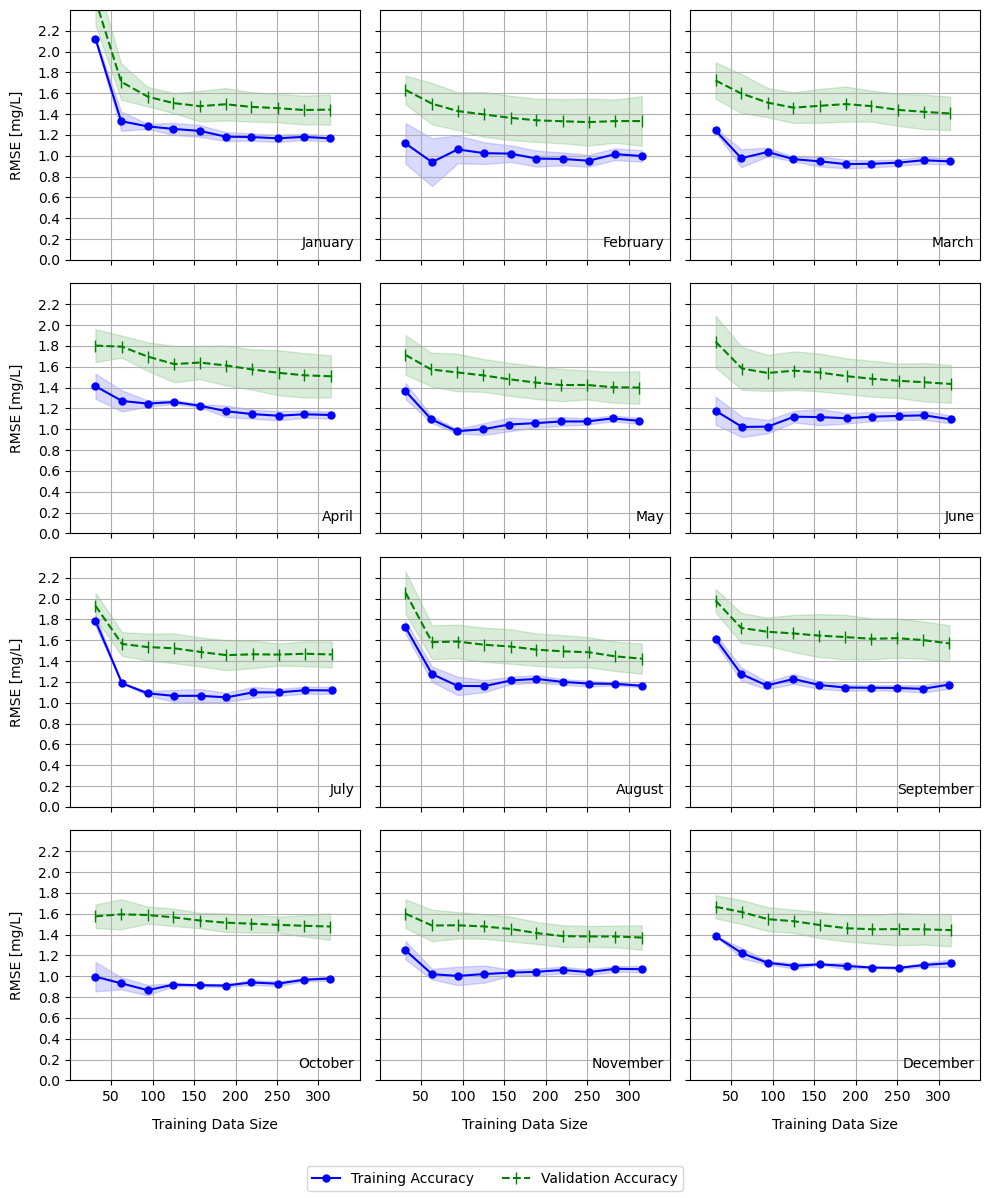

In [129]:
month_long = ['January', 'February', 'March', 'April','May', 'June','July','August','September','October','November','December']

fig = plt.figure(figsize=(10, 12))
# Create a single legend handle list
legend_handles = []
for i, month in enumerate(months):
        
    ax = fig.add_subplot(4, 3, i+1)
    
    line1, = ax.plot(train_sizes_opt_nss[month], train_mean_opt_nss[month], color='blue', marker='o', markersize=5, label='Training Accuracy')
    ax.fill_between(train_sizes_opt_nss[month], train_mean_opt_nss[month] + train_std_opt_nss[month], train_mean_opt_nss[month] - train_std_opt_nss[month], alpha=0.15, color='blue')
    line2, = ax.plot(train_sizes_opt_nss[month], test_mean_opt_nss[month], color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
    ax.fill_between(train_sizes_opt_nss[month], test_mean_opt_nss[month] + test_std_opt_nss[month], test_mean_opt_nss[month] - test_std_opt_nss[month], alpha=0.15, color='green')
    ax.grid()
    ax.set_xlim(0,350)
    ax.set_xticks(np.arange(50, 301, 50))
    ax.set_ylim(0.2,2.4)
    ax.set_yticks(np.arange(0, 2.3, 0.2))
    #ax.legend(loc='lower right')
    ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
    # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
    if i in range(9,12):
                
        ax.set_xlabel('Training Data Size', labelpad = 10)
        
    # only add y label for the first column of subplot    
    if i in range(0,10,3):        
        ax.set_ylabel('RMSE [mg/L]',labelpad = 10)
        
                
    if i not in range(9,12):
        ax.set_xticklabels([])
    
    
    if i not in range(0,10,3): 
        ax.set_yticklabels([])

    # Collect legend handles from the first plot
    if i == 0:
        legend_handles.extend([line1, line2])


plt.tight_layout(rect=[0, 0.04, 1, 1])

# Create a single legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=2)
plt.savefig('learning_curves_opt_nss_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)
plt.show()

# MMSS default case

In [113]:
X_train_wss.to_numpy().shape

(392, 46)

In [114]:
# Calculate the learning curve parameters (default wss)

# Blank dictionaries to save learning curve parameters
train_mean_default_wss = {}
train_std_default_wss = {}
test_mean_default_wss = {}
test_std_default_wss = {}
train_sizes_default_wss = {}
train_scores_default_wss  = {}
test_scores_default_wss = {}



for i, month in enumerate(months):
    print(f'Currently Processing Data for Month: {month}')

    with open(f"X_train_{month}", 'rb') as file:
        X_train_wss = pickle.load(file)
    X_train_wss = X_train_wss.to_numpy()
    
    with open(f"y_train_{month}", 'rb') as file:
        y_train_wss = pickle.load(file)
    y_train_wss.reset_index(drop= True, inplace= True)
    
    with open(f"y_train_og_{month}", 'rb') as file:
        y_train_wss_og = pickle.load(file)
    y_train_wss_og.reset_index(drop= True, inplace= True)
    
    learning_curve_model_default_wss = RandomForestRegressor(random_state = 42, n_jobs=32)
    
    train_sizes_default_wss[month], train_scores_default_wss[month], test_scores_default_wss[month] = custom_learning_curve(learning_curve_model_default_wss, X_train_wss, y_train_wss, 
                                                                                                                            y_train_wss_og, 5, np.linspace(0.1, 1.0, 10))
    
    train_mean_default_wss[month] = np.mean(train_scores_default_wss[month], axis=1)
    train_std_default_wss[month] = np.std(train_scores_default_wss[month], axis=1)
    test_mean_default_wss[month] = np.mean(test_scores_default_wss[month], axis=1)
    test_std_default_wss[month] = np.std(test_scores_default_wss[month], axis=1)

Currently Processing Data for Month: jan
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157]
Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202

Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235]
Processing fold 4/5...
  Test set size: 78
test indices for this fold: [236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313]
Processing fold 5/5...
  Test set size: 78
test indices for this fold: [314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 

Processing fold 5/5...
  Test set size: 78
test indices for this fold: [314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391]


Currently Processing Data for Month: oct
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 1

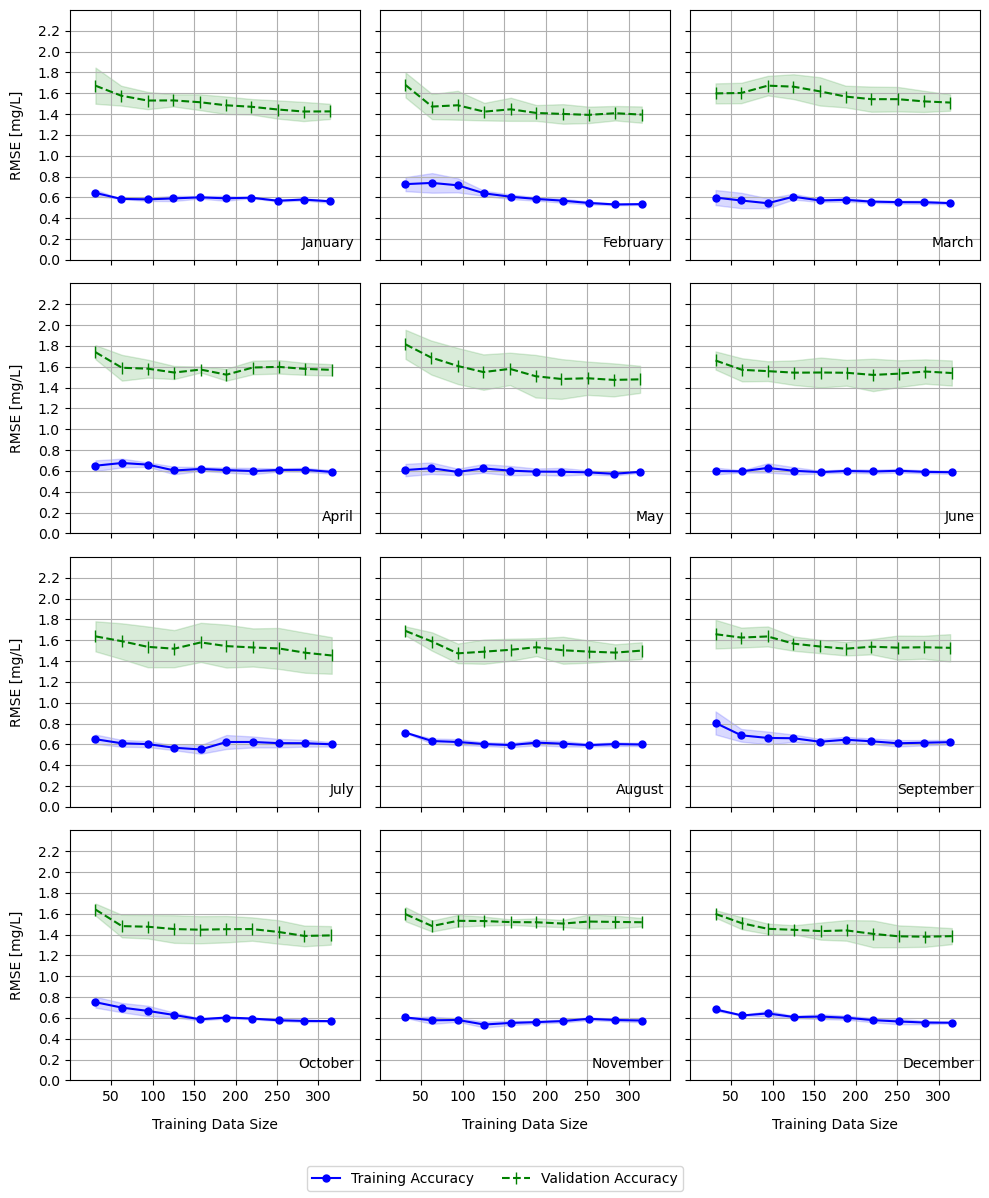

In [117]:
month_long = ['January', 'February', 'March', 'April','May', 'June','July','August','September','October','November','December']

fig = plt.figure(figsize=(10, 12))
# Create a single legend handle list
legend_handles = []
for i, month in enumerate(months):
        
    ax = fig.add_subplot(4, 3, i+1)
    
    line1, = ax.plot(train_sizes_default_wss[month], train_mean_default_wss[month], color='blue', marker='o', markersize=5, label='Training Accuracy')
    ax.fill_between(train_sizes_default_wss[month], train_mean_default_wss[month] + train_std_default_wss[month], train_mean_default_wss[month] - train_std_default_wss[month], alpha=0.15, color='blue')
    line2, = ax.plot(train_sizes_default_wss[month], test_mean_default_wss[month], color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
    ax.fill_between(train_sizes_default_wss[month], test_mean_default_wss[month] + test_std_default_wss[month], test_mean_default_wss[month] - test_std_default_wss[month], alpha=0.15, color='green')
    ax.grid()
    ax.set_xlim(0,350)
    ax.set_xticks(np.arange(50, 301, 50))
    ax.set_ylim(0.2,2.4)
    ax.set_yticks(np.arange(0, 2.3, 0.2))
    #ax.legend(loc='lower right')
    ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
    # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
    if i in range(9,12):
                
        ax.set_xlabel('Training Data Size', labelpad = 10)
        
    # only add y label for the first column of subplot    
    if i in range(0,10,3):        
        ax.set_ylabel('RMSE [mg/L]',labelpad = 10)
        
                
    if i not in range(9,12):
        ax.set_xticklabels([])
    
    
    if i not in range(0,10,3): 
        ax.set_yticklabels([])

    # Collect legend handles from the first plot
    if i == 0:
        legend_handles.extend([line1, line2])


plt.tight_layout(rect=[0, 0.04, 1, 1])

# Create a single legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=2)
plt.savefig('learning_curves_default_wss_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)
plt.show()

# MMRS optimized

In [118]:
opt_wss_best_params = {}

for i,month in enumerate(months):
    with open(f"study_opt_wss_bc_best_params_{month}", 'rb') as file:
        opt_wss_best_params_month = pickle.load(file)
    opt_wss_best_params[month] = opt_wss_best_params_month

In [120]:
# calculate learning curve parameters (OPT wss)

train_mean_opt_wss = {}
train_std_opt_wss = {}
test_mean_opt_wss = {}
test_std_opt_wss = {}
train_sizes_opt_wss = {}
train_scores_opt_wss  = {}
test_scores_opt_wss = {}

for i, month in enumerate(months):
    print(f'Currently Processing Data for Month: {month}')

    with open(f"X_train_{month}", 'rb') as file:
        X_train_wss = pickle.load(file)
    X_train_wss = X_train_wss.to_numpy()
    
    with open(f"y_train_{month}", 'rb') as file:
        y_train_wss = pickle.load(file)
    y_train_wss.reset_index(drop= True, inplace= True)
    
    with open(f"y_train_og_{month}", 'rb') as file:
        y_train_wss_og = pickle.load(file)
    y_train_wss_og.reset_index(drop= True, inplace= True)
        
    best_n_estimators_opt_merged = opt_wss_best_params[month]['n_estimators']
    best_max_depth_opt_merged = opt_wss_best_params[month]['max_depth']
    best_min_samples_split_opt_merged = opt_wss_best_params[month]['min_samples_split']
    best_min_samples_leaf_opt_merged = opt_wss_best_params[month]['min_samples_leaf']
    
    
    learning_curve_model_opt_wss = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged, max_depth = best_max_depth_opt_merged , 
                                              min_samples_split= best_min_samples_split_opt_merged, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged, random_state=42, n_jobs=32)
    
    train_sizes_opt_wss[month], train_scores_opt_wss[month], test_scores_opt_wss[month] = custom_learning_curve(learning_curve_model_opt_wss, X_train_wss, y_train_wss, 
                                                                                                                            y_train_wss_og, 5, np.linspace(0.1, 1.0, 10))
    train_mean_opt_wss[month] = np.mean(train_scores_opt_wss[month], axis=1)
    train_std_opt_wss[month] = np.std(train_scores_opt_wss[month], axis=1)
    test_mean_opt_wss[month] = np.mean(test_scores_opt_wss[month], axis=1)
    test_std_opt_wss[month] = np.std(test_scores_opt_wss[month], axis=1)

Currently Processing Data for Month: jan
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157]
Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202

Processing fold 3/5...
  Test set size: 78
test indices for this fold: [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235]
Processing fold 4/5...
  Test set size: 78
test indices for this fold: [236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313]
Processing fold 5/5...
  Test set size: 78
test indices for this fold: [314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 

Processing fold 5/5...
  Test set size: 78
test indices for this fold: [314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391]


Currently Processing Data for Month: oct
Processing fold 1/5...
  Test set size: 79
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
Processing fold 2/5...
  Test set size: 79
test indices for this fold: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 1

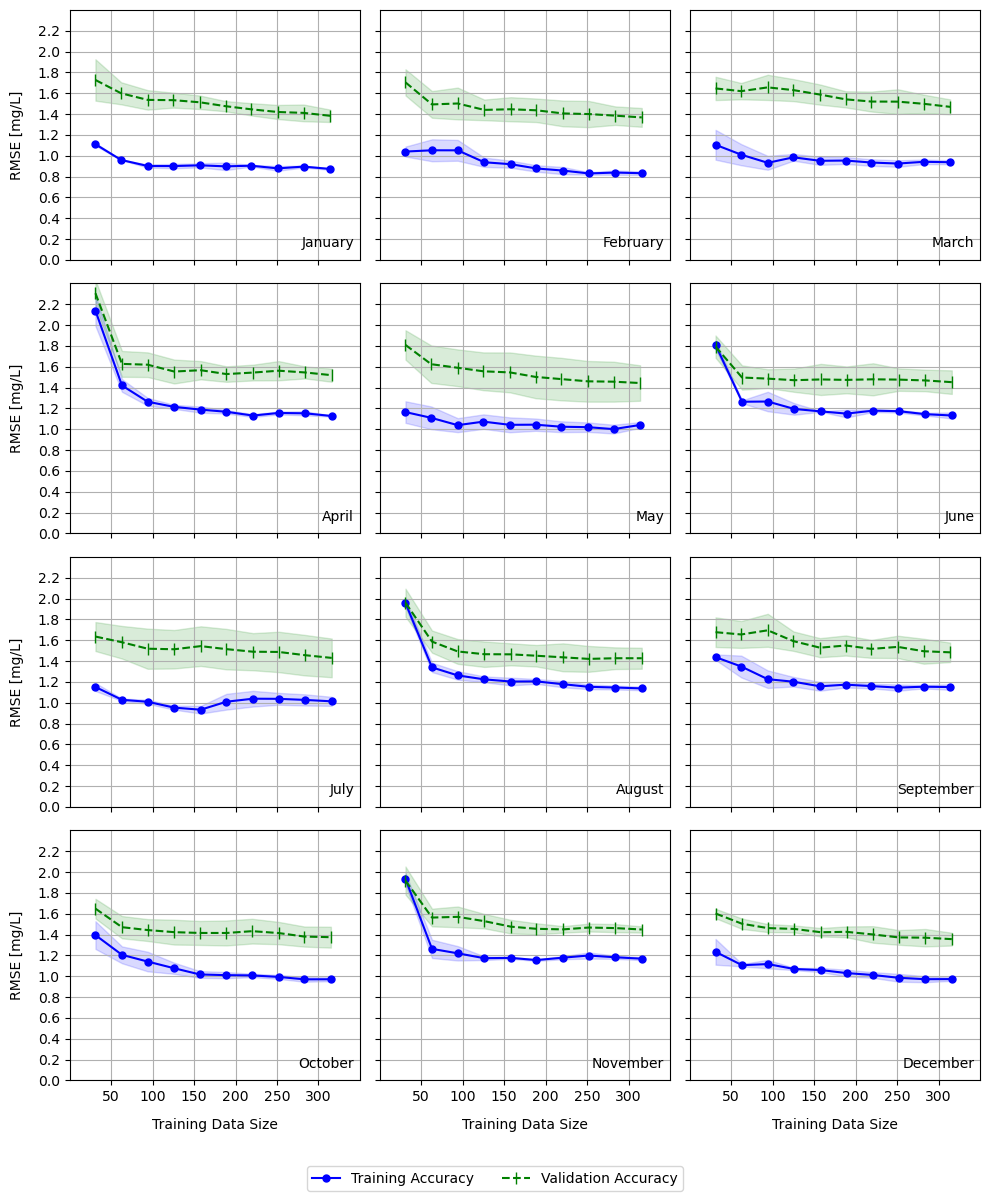

In [124]:
month_long = ['January', 'February', 'March', 'April','May', 'June','July','August','September','October','November','December']

fig = plt.figure(figsize=(10, 12))
# Create a single legend handle list
legend_handles = []
for i, month in enumerate(months):
        
    ax = fig.add_subplot(4, 3, i+1)
    
    line1, = ax.plot(train_sizes_opt_wss[month], train_mean_opt_wss[month], color='blue', marker='o', markersize=5, label='Training Accuracy')
    ax.fill_between(train_sizes_opt_wss[month], train_mean_opt_wss[month] + train_std_opt_wss[month], train_mean_opt_wss[month] - train_std_opt_wss[month], alpha=0.15, color='blue')
    line2, = ax.plot(train_sizes_opt_wss[month], test_mean_opt_wss[month], color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
    ax.fill_between(train_sizes_opt_wss[month], test_mean_opt_wss[month] + test_std_opt_wss[month], test_mean_opt_wss[month] - test_std_opt_wss[month], alpha=0.15, color='green')
    ax.grid()
    ax.set_xlim(0,350)
    ax.set_xticks(np.arange(50, 301, 50))
    ax.set_ylim(0.2,2.4)
    ax.set_yticks(np.arange(0, 2.3, 0.2))
    #ax.legend(loc='lower right')
    ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
    # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
    if i in range(9,12):
                
        ax.set_xlabel('Training Data Size', labelpad = 10)
        
    # only add y label for the first column of subplot    
    if i in range(0,10,3):        
        ax.set_ylabel('RMSE [mg/L]',labelpad = 10)
        
                
    if i not in range(9,12):
        ax.set_xticklabels([])
    
    
    if i not in range(0,10,3): 
        ax.set_yticklabels([])

    # Collect legend handles from the first plot
    if i == 0:
        legend_handles.extend([line1, line2])


plt.tight_layout(rect=[0, 0.04, 1, 1])

# Create a single legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=2)
plt.savefig('learning_curves_opt_wss_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)
plt.show()

# AM SBRS default case

In [142]:
# Calculate the learning curve parameters (default wss)





with open(f"merged_dfs_scaled_sbrs", 'rb') as file:
    merged_dfs_scaled_sbrs = pickle.load(file)


with open(f"list_80_percent_sbrs", 'rb') as file:
    list_80_percent_sbrs = pickle.load(file)


learning_curve_model_default_sbrs = RandomForestRegressor(random_state = 42, n_jobs=32)

train_sizes_default_sbrs, train_scores_default_sbrs, test_scores_default_sbrs = learning_curve_LLOCV(merged_dfs_scaled_sbrs, 5, list_80_percent_sbrs, learning_curve_model_default_sbrs, np.linspace(0.1, 1.0, 10))

train_mean_default_sbrs = np.mean(train_scores_default_sbrs, axis=1)
train_std_default_sbrs = np.std(train_scores_default_sbrs, axis=1)
test_mean_default_sbrs = np.mean(test_scores_default_sbrs, axis=1)
test_std_default_sbrs = np.std(test_scores_default_sbrs, axis=1)

Processing fold 1/5...
  Test set size: 80
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Processing fold 2/5...
  Test set size: 80
test indices for this fold: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159]
Processing fold 3/5...
  Test set size: 80
test indices for this fold: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 2

# AM SBRS optimized

In [152]:
# Calculate the learning curve parameters (default wss)



with open(f"merged_dfs_scaled_sbrs", 'rb') as file:
    merged_dfs_scaled_sbrs = pickle.load(file)


with open(f"list_80_percent_sbrs", 'rb') as file:
    list_80_percent_sbrs = pickle.load(file)

    
with open(f"SBRS_llocv_best_params", 'rb') as file:
    best_params_sbrs = pickle.load(file)
    

best_n_estimators_opt_merged = best_params_sbrs['n_estimators']
best_max_depth_opt_merged = best_params_sbrs['max_depth']
best_min_samples_split_opt_merged = best_params_sbrs['min_samples_split']
best_min_samples_leaf_opt_merged = best_params_sbrs['min_samples_leaf']    
    
    
learning_curve_model_opt_sbrs = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged, max_depth = best_max_depth_opt_merged , 
                                              min_samples_split= best_min_samples_split_opt_merged, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged, random_state=42, n_jobs=32)

train_sizes_opt_sbrs, train_scores_opt_sbrs, test_scores_opt_sbrs = learning_curve_LLOCV(merged_dfs_scaled_sbrs, 5, list_80_percent_sbrs, learning_curve_model_opt_sbrs, np.linspace(0.1, 1.0, 10))

train_mean_opt_sbrs = np.mean(train_scores_opt_sbrs, axis=1)
train_std_opt_sbrs = np.std(train_scores_opt_sbrs, axis=1)
test_mean_opt_sbrs = np.mean(test_scores_opt_sbrs, axis=1)
test_std_opt_sbrs = np.std(test_scores_opt_sbrs, axis=1)

Processing fold 1/5...
  Test set size: 80
test indices for this fold: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Processing fold 2/5...
  Test set size: 80
test indices for this fold: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159]
Processing fold 3/5...
  Test set size: 80
test indices for this fold: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 2

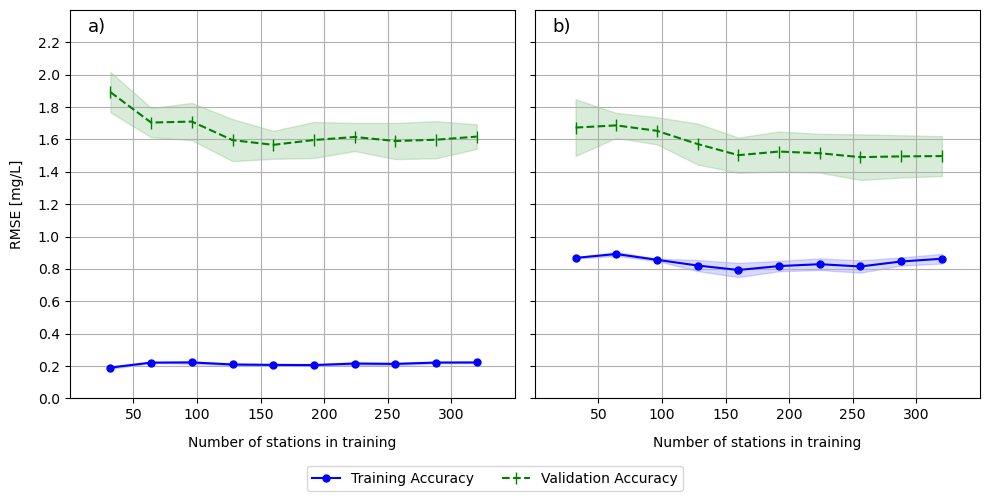

In [173]:
fig = plt.figure(figsize=(10, 5))


ax = fig.add_subplot(1, 2, 1)

line1, = ax.plot(train_sizes_default_sbrs, train_mean_default_sbrs, color='blue', marker='o', markersize=5, label='Training Accuracy')
ax.fill_between(train_sizes_default_sbrs, train_mean_default_sbrs + train_std_default_sbrs, train_mean_default_sbrs - train_std_default_sbrs, alpha=0.15, color='blue')
line2, = ax.plot(train_sizes_default_sbrs, test_mean_default_sbrs, color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
ax.fill_between(train_sizes_default_sbrs, test_mean_default_sbrs + test_std_default_sbrs, test_mean_default_sbrs - test_std_default_sbrs, alpha=0.15, color='green')
ax.grid()
ax.set_xlim(0,350)
ax.set_xticks(np.arange(50, 301, 50))
ax.set_ylim(0.2,2.4)
ax.set_yticks(np.arange(0, 2.3, 0.2))
#ax.legend(loc='lower right')
#ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
# only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
#ax.legend()

ax.set_xlabel('Number of stations in training', labelpad = 10)
ax.set_ylabel('RMSE [mg/L]',labelpad = 10)

ax.text(0.04, 0.98, "a)",transform=ax.transAxes,fontsize=13,ha='left',va="top" )





ax = fig.add_subplot(1, 2, 2)

line1, = ax.plot(train_sizes_opt_sbrs, train_mean_opt_sbrs, color='blue', marker='o', markersize=5, label='Training Accuracy')
ax.fill_between(train_sizes_opt_sbrs, train_mean_opt_sbrs + train_std_opt_sbrs, train_mean_opt_sbrs - train_std_opt_sbrs, alpha=0.15, color='blue')
line2, = ax.plot(train_sizes_opt_sbrs, test_mean_opt_sbrs, color='green', marker='|', markersize=8, linestyle='--', label='Validation Accuracy')
ax.fill_between(train_sizes_opt_sbrs, test_mean_opt_sbrs + test_std_opt_sbrs, test_mean_opt_sbrs - test_std_opt_sbrs, alpha=0.15, color='green')
ax.grid()
ax.set_xlim(0,350)
ax.set_xticks(np.arange(50, 301, 50))
ax.set_ylim(0.2,2.4)
ax.set_yticks(np.arange(0, 2.3, 0.2))
ax.tick_params(labelleft=False)
#ax.legend(loc='lower right')
#ax.text(0.98, 0.05, month_long[i],transform=ax.transAxes,fontsize=10,ha='right' )
# only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
#ax.legend()

ax.set_xlabel('Number of stations in training', labelpad = 10)
#ax.set_ylabel('RMSE [mg/L]',labelpad = 10)
ax.text(0.04, 0.98, "b)",transform=ax.transAxes,fontsize=13,ha='left',va="top" )


# Collect legend handles from the first plot
#if i == 0:
#    legend_handles.extend([line1, line2])


plt.tight_layout(rect=[0, 0.06, 1, 1])

# Create a single legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=2)
plt.savefig('learning_curves_default_vs_opt_300dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=300)
plt.show()